In [112]:
import numpy as np
from scipy.stats import norm
from scipy import integrate
from scipy.optimize import fsolve
import matplotlib
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [126]:
def sim(r_0, drift, diffusion, N, T, N_paths):
    delta_t = T / N
    paths = np.full((N_paths, N+1), np.nan)
    paths[:, 0] = r_0
    for i in range(N):
        Z = np.random.normal(0, 1, N_paths)  # standard Brownian increments
        paths[:, i+1] = paths[:, i] - drift*paths[:, i]*delta_t + diffusion*np.sqrt(delta_t)*Z
    return paths


def phi_func(t, a, b, lambda_):
    return a + b*((1 - np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t))


def get_yield(r, N, delta_t=1/252, conf_alpha=0.05):
    T = N * delta_t
    bond_prices = np.exp(-delta_t * np.sum(r[:, 1:N+1], axis=1))
    bond_price = np.sum(bond_prices) / r.shape[0]
    bond_price_ci = np.std(bond_prices, ddof=1) * norm.ppf(1 - conf_alpha/2) / np.sqrt(r.shape[0])
    yield_rate = -np.log(bond_price) / T
    yield_rate_ci = (-np.log(bond_price + bond_price_ci) / T, -np.log(bond_price - bond_price_ci) / T)
    # yield_rates = np.sum(r[:, 1:N+1], axis=1) / N
    # yield_rate = np.mean(yield_rates)
    # yield_rate_ci = (yield_rate - np.std(yield_rates, ddof=1)*norm.ppf(1 - conf_alpha/2)/np.sqrt(r.shape[0]), yield_rate + np.std(yield_rates, ddof=1)*norm.ppf(1 - conf_alpha/2)/np.sqrt(r.shape[0]))
    return yield_rate, yield_rate_ci


def analytical_bond_price(x_t, y_t, t, T, phi_func, alpha, beta, sigma, eta, a, b, lambda_):
    tau = T - t
    Phi, err = integrate.quad(phi_func, t, T, args=(a, b, lambda_))
    A = -Phi + sigma**2 * ((2*alpha*tau - np.exp(-2*alpha*tau) + 4*np.exp(-alpha*tau) - 3) / (4 * alpha**3)) + eta**2 * ((2*beta*tau - np.exp(-2*beta*tau) + 4*np.exp(-beta*tau) - 3) / (4 * beta**3))
    B = (1 - np.exp(-alpha*tau)) / alpha
    C = (1 - np.exp(-beta*tau)) / beta
    return np.exp(A - B*x_t - C*y_t)


def annuity(t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_):
    tenor = np.arange(tau_0, tau_n, delta_tau) + delta_tau
    return np.sum([analytical_bond_price(x_t, y_t, t, T, phi_func, alpha, beta, sigma, eta, a, b, lambda_) for T in tenor]) * delta_tau


def swap_rate(t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_):
    return (analytical_bond_price(x_t, y_t, t, tau_0, phi_func, alpha, beta, sigma, eta, a, b, lambda_) - analytical_bond_price(x_t, y_t, t, tau_n, phi_func, alpha, beta, sigma, eta, a, b, lambda_)) / annuity(t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_)


def get_swaption_price(r, F, tau_0, tau_n, delta_tau, x, y, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_):
    ind = int(tau_0 / delta_t)
    payoffs = np.maximum(np.array([swap_rate(tau_0, tau_0, tau_n, delta_tau, x_t[ind], y_t[ind], delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_) for x_t, y_t in zip(x, y)]) - F, 0)
    annuities = np.array([annuity(tau_0, tau_0, tau_n, delta_tau, x_t[ind], y_t[ind], delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_) for x_t, y_t in zip(x, y)])
    swaption_prices = np.exp(-delta_t * np.sum(r[:, 1:ind+1], axis=1)) * payoffs * annuities
    return np.mean(swaption_prices)


def LSM_swaption_price(theta, S_t, F, t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_):
    dp = (np.log(S_t / F) + 0.5*(tau_0 - t)*theta**2) / (eta * np.sqrt(tau_0 - t))
    dm = (np.log(S_t / F) - 0.5*(tau_0 - t)*theta**2) / (eta * np.sqrt(tau_0 - t))
    return (S_t * norm.cdf(dp) - F * norm.cdf(dm)) * annuity(t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_)


def implied_volatility(price, init_guess, params):
    def func_root(theta, *args):
        price, S_t, F, t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_ = args
        return LSM_swaption_price(theta, S_t, F, t, tau_0, tau_n, delta_tau, x_t, y_t, delta_t, phi_func, alpha, beta, sigma, eta, a, b, lambda_) - price
    sol = fsolve(func_root, init_guess, args=(price,)+params)
    return sol

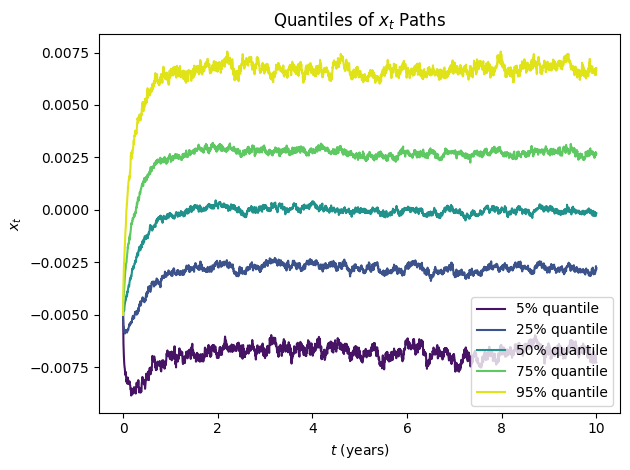

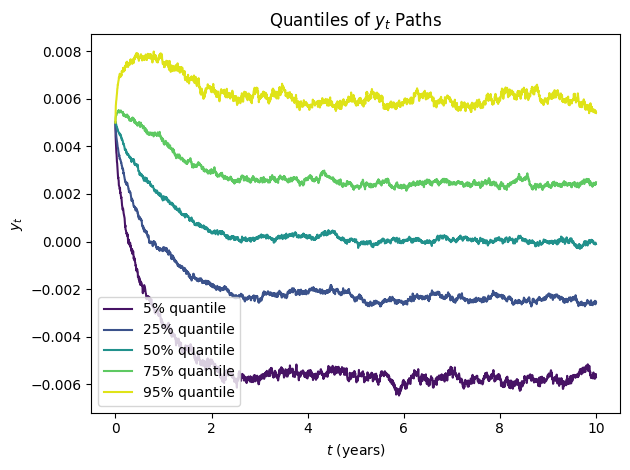

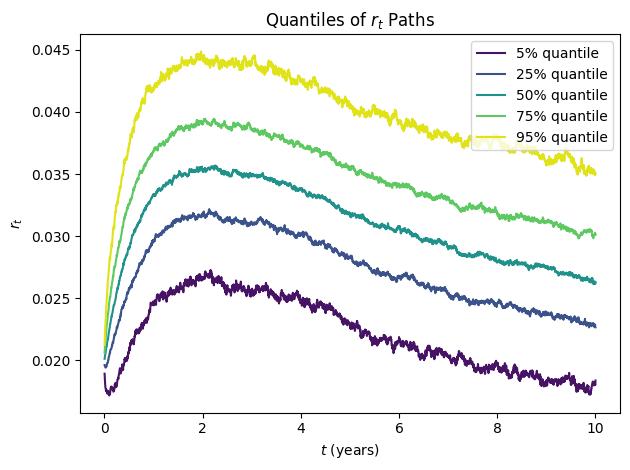

In [124]:
"""Q2 main run"""
np.random.seed(1928)

x_0 = -0.005
y_0 = 0.005
alpha = 3
beta = 1
sigma = 0.01
eta = 0.005
a = 0.02
b = 0.05
lambda_ = 0.75

t = np.linspace(0, 10, 2521)
phi = phi_func(t, a, b, lambda_)
x = sim(x_0, alpha, sigma, 2520, 10, 1000)
y = sim(y_0, beta, eta, 2520, 10, 1000)
r = phi + x + y

# fig, ax = plt.subplots()
# ax.plot(t, x[0], label=f"$x_t$")
# ax.plot(t, y[0], label=f"$y_t$")
# ax.plot(t, r[0], label=f"$r_t$")
# ax.set(xlabel='$t$ (years)', ylabel='rate')
# ax.set_title("Sample Paths of $x_t$, $y_t$, and $r_t$")
# ax.legend()
# plt.tight_layout()
# plt.show()
# fig.savefig("media/sample_paths.png")

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
cmap = matplotlib.cm.get_cmap('viridis')

fig, ax = plt.subplots()
for quantile in quantiles:
    ax.plot(t, np.quantile(x, quantile, axis=0), label=f"{int(quantile*100)}% quantile", color=cmap(quantile))
# ax.plot(t, x[-1], label=f"sample $x_t$ path", alpha=0.3, color='k')
ax.set(xlabel='$t$ (years)', ylabel='$x_t$')
ax.set_title("Quantiles of $x_t$ Paths")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/x_t.png")

fig, ax = plt.subplots()
for quantile in quantiles:
    ax.plot(t, np.quantile(y, quantile, axis=0), label=f"{int(quantile*100)}% quantile", color=cmap(quantile))
# ax.plot(t, y[-1], label=f"sample $y_t$ path", alpha=0.3, color='k')
ax.set(xlabel='$t$ (years)', ylabel='$y_t$')
ax.set_title("Quantiles of $y_t$ Paths")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/y_t.png")

fig, ax = plt.subplots()
for quantile in quantiles:
    ax.plot(t, np.quantile(r, quantile, axis=0), label=f"{int(quantile*100)}% quantile", color=cmap(quantile))
# ax.plot(t, r[-1], label=f"sample $r_t$ path", alpha=0.3, color='k')
ax.set(xlabel='$t$ (years)', ylabel='$r_t$')
ax.set_title("Quantiles of $r_t$ Paths")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/r_t.png")

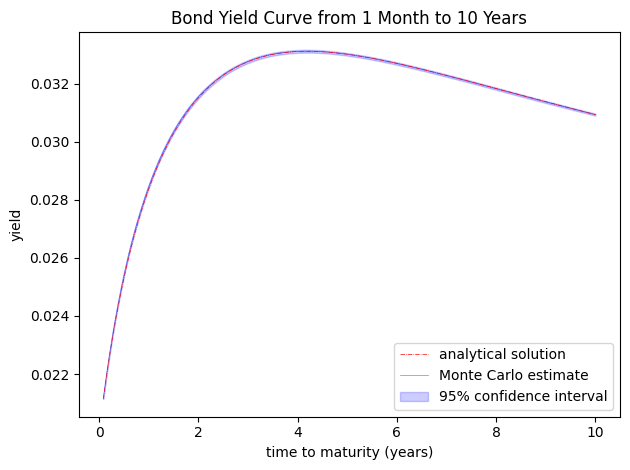

In [34]:
"""Q3 main run"""
np.random.seed(1928)

x = sim(x_0, alpha, sigma, 2520, 10, 10000)
y = sim(y_0, beta, eta, 2520, 10, 10000)
r = phi + x + y

analytical_bond_prices = np.array([analytical_bond_price(x_0, y_0, 0, N/252, phi_func, alpha, beta, sigma, eta, a, b, lambda_) for N in range(21, 2521)])
analytical_yields = -np.log(analytical_bond_prices) / (np.arange(21, 2521) / 252)

yields = np.full(2521, np.nan)
lower_cis = np.full(2521, np.nan)
upper_cis = np.full(2521, np.nan)
for i in range(21, 2521):  # 1 month (assuming each month has 21 trading days) ~ 10 years
    yields[i], (lower_cis[i], upper_cis[i]) = get_yield(r, i)

fig, ax = plt.subplots()
ax.plot(np.arange(21, 2521) / 252, analytical_yields, label="analytical solution", linewidth=0.5, color='r', linestyle='dashdot', zorder=10)
ax.plot(t, yields, label="Monte Carlo estimate", linewidth=0.5, color='b', alpha=0.5, zorder=5)
ax.fill_between(t, lower_cis, upper_cis, color='b', alpha=.2, label="95% confidence interval", zorder=0)
ax.set(xlabel='time to maturity (years)', ylabel='yield')
ax.set_title("Bond Yield Curve from 1 Month to 10 Years")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/yield.png")

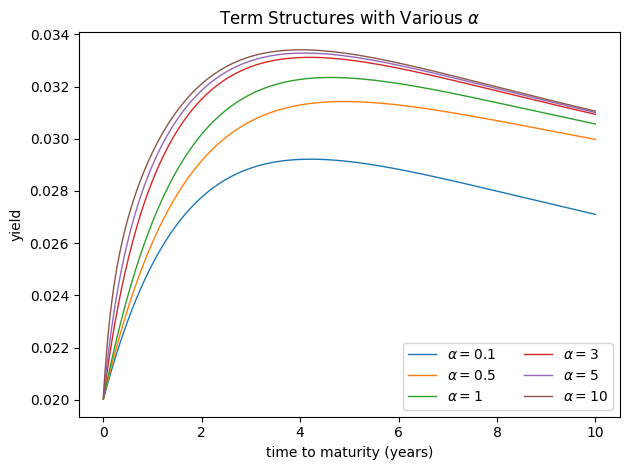

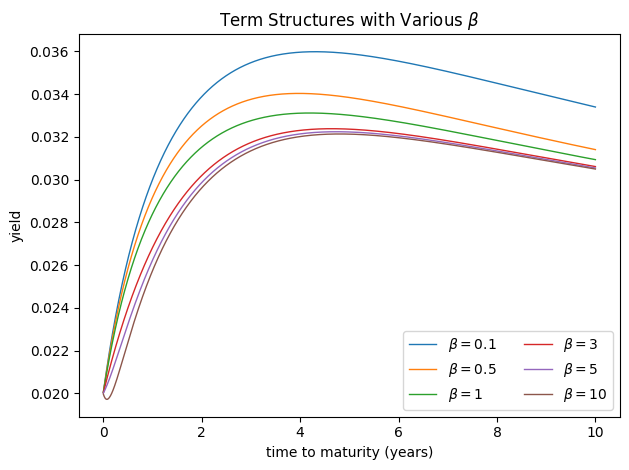

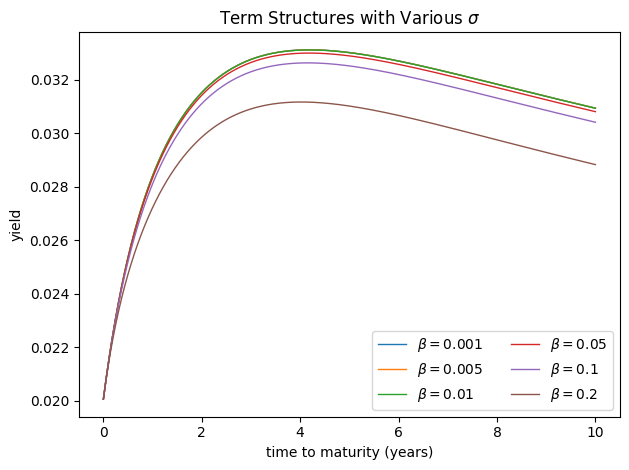

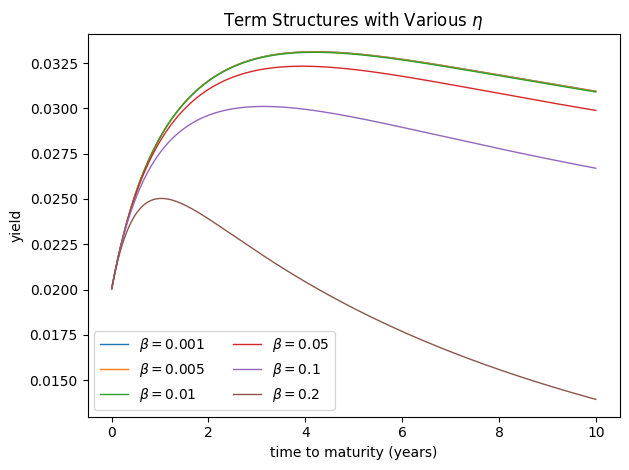

In [127]:
"""Q4 main run"""
# alpha
alphas = [0.1, 0.5, 1, 3, 5, 10]
fig, ax = plt.subplots()
for alpha_ in alphas:
    analytical_bond_prices = np.array([analytical_bond_price(x_0, y_0, 0, N/252, phi_func, alpha_, beta, sigma, eta, a, b, lambda_) for N in range(1, 2521)])
    analytical_yields = -np.log(analytical_bond_prices) / (np.arange(1, 2521) / 252)
    ax.plot(np.arange(1, 2521) / 252, analytical_yields, linewidth=1, label=r"$\alpha$" + f"$ = {{{alpha_}}}$")
ax.set(xlabel='time to maturity (years)', ylabel='yield')
ax.set_title(r"Term Structures with Various $\alpha$")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()
fig.savefig("media/alpha.png")

# beta
betas = [0.1, 0.5, 1, 3, 5, 10]
fig, ax = plt.subplots()
for beta_ in betas:
    analytical_bond_prices = np.array([analytical_bond_price(x_0, y_0, 0, N/252, phi_func, alpha, beta_, sigma, eta, a, b, lambda_) for N in range(1, 2521)])
    analytical_yields = -np.log(analytical_bond_prices) / (np.arange(1, 2521) / 252)
    ax.plot(np.arange(1, 2521) / 252, analytical_yields, linewidth=1, label=r"$\beta$" + f"$ = {{{beta_}}}$")
ax.set(xlabel='time to maturity (years)', ylabel='yield')
ax.set_title(r"Term Structures with Various $\beta$")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()
fig.savefig("media/beta.png")

# sigma
sigmas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
fig, ax = plt.subplots()
for sigma_ in sigmas:
    analytical_bond_prices = np.array([analytical_bond_price(x_0, y_0, 0, N/252, phi_func, alpha, beta, sigma_, eta, a, b, lambda_) for N in range(1, 2521)])
    analytical_yields = -np.log(analytical_bond_prices) / (np.arange(1, 2521) / 252)
    ax.plot(np.arange(1, 2521) / 252, analytical_yields, linewidth=1, label=r"$\beta$" + f"$ = {{{sigma_}}}$")
ax.set(xlabel='time to maturity (years)', ylabel='yield')
ax.set_title(r"Term Structures with Various $\sigma$")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()
fig.savefig("media/sigma.png")

# eta
etas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
fig, ax = plt.subplots()
for eta_ in etas:
    analytical_bond_prices = np.array([analytical_bond_price(x_0, y_0, 0, N/252, phi_func, alpha, beta, sigma, eta_, a, b, lambda_) for N in range(1, 2521)])
    analytical_yields = -np.log(analytical_bond_prices) / (np.arange(1, 2521) / 252)
    ax.plot(np.arange(1, 2521) / 252, analytical_yields, linewidth=1, label=r"$\beta$" + f"$ = {{{eta_}}}$")
ax.set(xlabel='time to maturity (years)', ylabel='yield')
ax.set_title(r"Term Structures with Various $\eta$")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()
fig.savefig("media/eta.png")

/Users/joshuakim/Desktop/Graduate/MMF/FALL2022/MMF1928/Projects/Project 3/venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


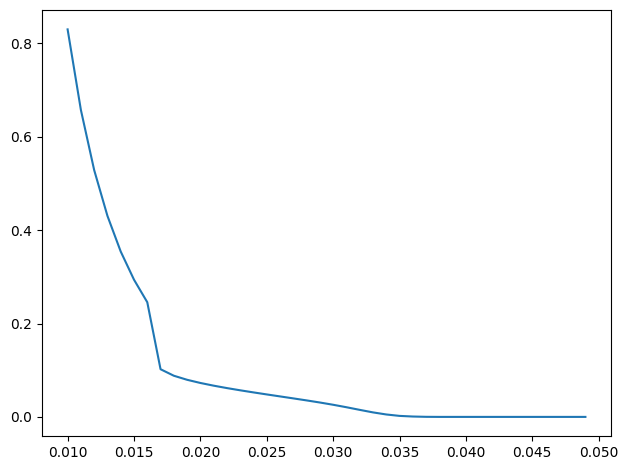

In [128]:
"""Q5 main run"""
np.random.seed(1928)

x = sim(x_0, alpha, sigma, 2520, 10, 1000)
y = sim(y_0, beta, eta, 2520, 10, 1000)
r = phi + x + y

F = swap_rate(0, 3, 6, 0.25, x_0, y_0, 1/252, phi_func, alpha, beta, sigma, eta, a, b, lambda_)  # swaption strike rate
strikes = np.arange(0.01, 0.05, 0.001)
swaption_prices = [get_swaption_price(r, K, 3, 6, 0.25, x, y, 1/252, phi_func, alpha, beta, sigma, eta, a, b, lambda_) for K in strikes]
black_vol = [implied_volatility(swaption_price, strike, (strike, strike, 0, 3, 6, 0.25, x_0, y_0, 1/252, phi_func, alpha, beta, sigma, eta, a, b, lambda_)) for swaption_price, strike in zip(swaption_prices, strikes)]

fig, ax = plt.subplots()
# ax.plot(strikes, swaption_prices, label="swaption price")
ax.plot(strikes, black_vol, label="Black implied volatility")
# ax.set(xlabel='strike interest rate', ylabel='swaption price')
# ax.set_title(r"Swaption Prices for Varying Strike Rate $F \in [0.01, 0.05]$")
# ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("media/swaption_price.png")